# 1. 라이브러리 버전 확인

필요한 라이브러리 준비하는 거부터 시작!!

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

import copy
import cv2
import PIL
from PIL import Image

print(tf.__version__)
print(np.__version__)
print(cv2.__version__)
print(PIL.__version__)

2.9.2
1.21.6
4.6.0
7.1.2


# 2. CAM 구현하기

## (1) 데이터셋 준비 및 학습

먼저 이미지 데이터셋을 불러온 뒤 학습할 수 있도록 전처리가 먼저 이루어져야겠죠~~ 그리고 학습을 한 뒤 학습 데이터를 저장까지 해야 합니다.

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/stanford_dogs/0.2.0.incompleteHYK5GI/stanford_dogs-train.tfrecord*...:   0%|  …

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/stanford_dogs/0.2.0.incompleteHYK5GI/stanford_dogs-test.tfrecord*...:   0%|   …

Dataset stanford_dogs downloaded and prepared to ~/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


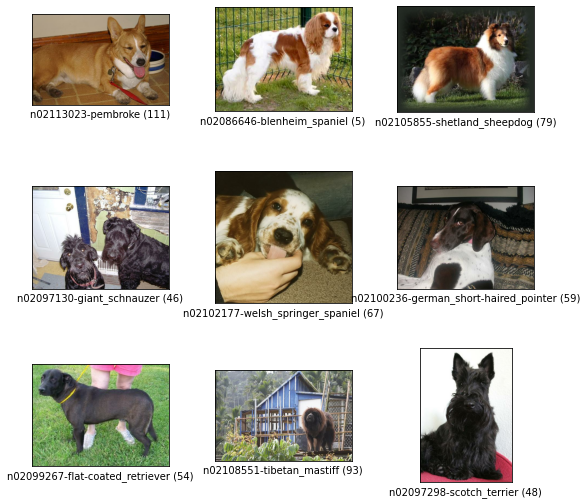

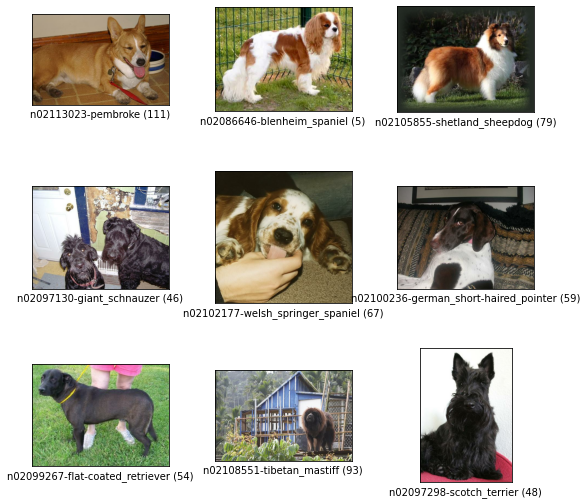

In [4]:
tfds.show_examples(ds_train, ds_info)

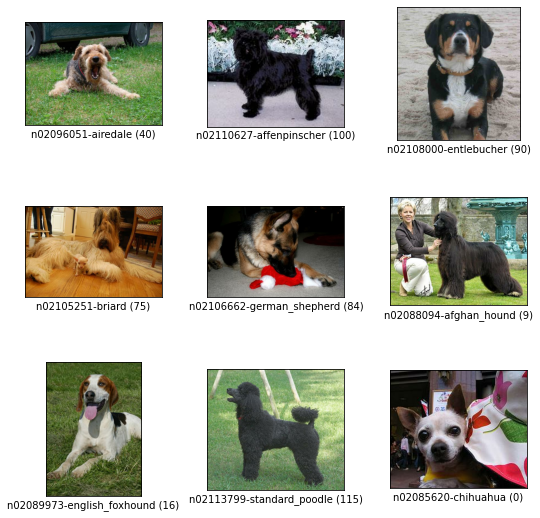

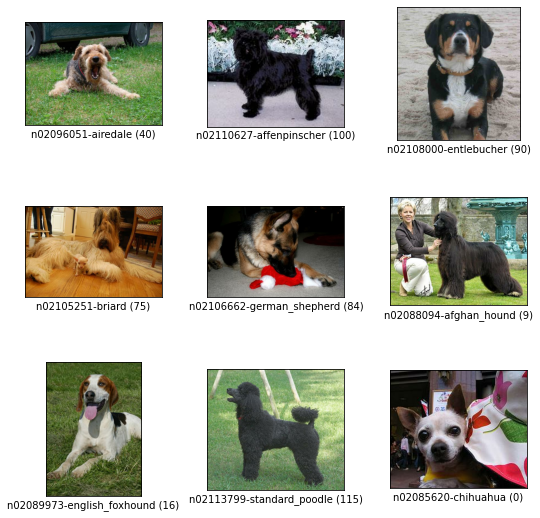

In [5]:
tfds.show_examples(ds_test, ds_info)

CAM 모델을 얻어내기 위한 모델을 만들 때는 ResNet50을 기반으로 했었죠. 그리고 그 뒤에 필요한 레이어를 붙이는 식으로 해서 기본 모델을 구현합니다. 

In [6]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,    # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',      # GAP를 적용  
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

94765736/94765736 [==============================] - 1s 0us/step


In [7]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [8]:
def normalize_and_resize_img(input):
  # Normalizes images : `uint8` -> `float32`
  image = tf.image.resize(input['image'], [224, 224])
  input['image'] = tf.cast(image, tf.float32) / 255.
  return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
  ds = ds.map(
      normalize_and_resize_img,
      num_parallel_calls=2
  )
  ds = ds.batch(batch_size)
  if not is_test:
    ds = ds.repeat()
    ds = ds.shuffle(200)

  ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
  return ds

In [9]:
# 데이터셋에 전처리와 배치처리를 적용합니다. 
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


In [10]:
# 이제 모델을 컴파일 하고 학습시킵니다.
cam_model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

histroy_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 177s 212ms/step - loss: 2.2231 - accuracy: 0.4438 - val_loss: 3.3260 - val_accuracy: 0.2161
Epoch 2/20
750/750 [==============================] - 161s 214ms/step - loss: 0.7058 - accuracy: 0.8096 - val_loss: 1.1124 - val_accuracy: 0.6744
Epoch 3/20
750/750 [==============================] - 162s 215ms/step - loss: 0.2044 - accuracy: 0.9608 - val_loss: 0.9455 - val_accuracy: 0.7200
Epoch 4/20
750/750 [==============================] - 161s 215ms/step - loss: 0.0483 - accuracy: 0.9973 - val_loss: 0.8999 - val_accuracy: 0.7423
Epoch 5/20
750/750 [==============================] - 161s 215ms/step - loss: 0.0199 - accuracy: 0.9998 - val_loss: 0.9158 - val_accuracy: 0.7371
Epoch 6/20
750/750 [==============================] - 161s 215ms/step - loss: 0.0127 - accuracy: 1.0000 - val_loss: 0.9289 - val_accuracy: 0.7403
Epoch 7/20
750/750 [==============================] - 161s 215ms/step - loss: 0.0094 - accuracy: 1.0000 - val_loss: 0.9308 -

In [11]:
import os

cam_model_path = '/content/drive/MyDrive/AIFFEL/GoingDeeper/10/cam_model_project.h5'
cam_model.save(cam_model_path)
print("저장 완료!")

저장 완료!


## (2) CAM 구현

메모리 부족으로 인해 실습에 문제가 생기는 것을 방지하기 위해 여기서부터는 커널 재시작을 하겠습니다!!

In [1]:
# 커널 재시작 이후 실습을 위해, 이전 스텝의 코드를 모아서 한꺼번에 실행합니다.
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import copy
import cv2
from PIL import Image

(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/stanford_dogs/0.2.0.incomplete7I4AX2/stanford_dogs-train.tfrecord*...:   0%|  …

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/stanford_dogs/0.2.0.incomplete7I4AX2/stanford_dogs-test.tfrecord*...:   0%|   …

Dataset stanford_dogs downloaded and prepared to ~/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


이제 학습된 모델에서 CAM을 생성해 봅시다. CAM 생성 작업은 데이터셋 배치 단위가 아니라 개별 이미지 데이터 단위로 이루어지기 때문에, `get_one()` 함수로 데이터셋에서 한 장씩 뽑을 수 있도록 했습니다.

In [7]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

67


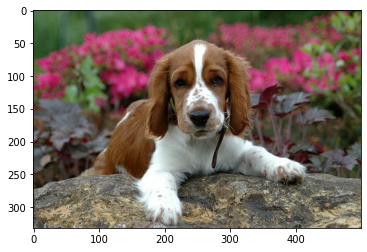

In [8]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

이제 데이터가 준비되었으니, CAM을 생성하기 위해 준비된 학습 모델을 불러와 줍시다!!

In [9]:
import os
cam_model_path = '/content/drive/MyDrive/AIFFEL/GoingDeeper/10/cam_model_project.h5'
cam_model = tf.keras.models.load_model(cam_model_path)

CAM을 생성하기 위해서는 (1)특성 맵 (2)클래스별 확률을 얻기 위한 소프트맥스 레이어의 가중치, (3)원하는 클래스의 출력값 이 세가지가 필요합니다. 또 이미지에서 모델이 어떤 부분을 보는지 직관적으로 확인하려면 네트워크에서 나온 CAM을 입력 이미지 사이즈와 같게 만들어 함께 시각화해야 할 것입니다. 이를 고려해서 model과 item을 받았을 때 입력 이미지와 동일한 크기의 CAM을 반환하는 함수를 만들어야 합니다.

generate_cam() 을 구현하기 위해 아래에서는 conv_ouputs와 같이 특정 레이어의 결과값을 output으로 받기 위해 새로운 모델을 정의하고, feedforward를 거친 후 CAM을 계산하도록 구현하였습니다. 마지막에는 입력 이미지의 크기에 맞춰 CAM을 resize해 주었습니다.

In [10]:
def generate_cam(model, item):
  item = copy.deepcopy(item)
  width = item['image'].shape[1]
  height = item['image'].shape[0]

  img_tensor, class_idx = normalize_and_resize_img(item)

  # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
  # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있습니다.
  cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
  conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
  conv_outputs = conv_outputs[0, :, :, :]
    
  # 모델의 weight activation은 마지막 layer에 있습니다.
  class_weights = model.layers[-1].get_weights()[0] 
    
  cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
  for i, w in enumerate(class_weights[:, class_idx]):
      # conv_outputs의 i번째 채널과 i번째 weight를 곱해서 누적하면 활성화된 정도가 나타날 겁니다.
      cam_image += w * conv_outputs[:, :, i]

  cam_image /= np.max(cam_image) # activation score를 normalize합니다.
  cam_image = cam_image.numpy()
  cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
  return cam_image



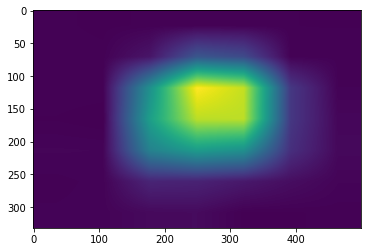

In [11]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [12]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

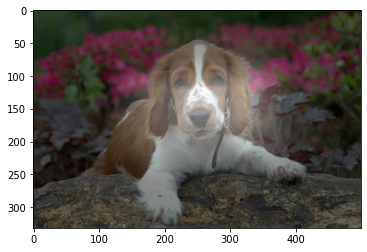

In [13]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

## (3) Grad-CAM 구현하기

적용 모델을 유연하게 선택할 수 있는 Grad-CAM의 특성 상 위에서 만들었던 모델을 다시 활용해도 괜찮기 때문에 관찰 대상 모델은 `cam_model`을 그대로 활용합시다.

108


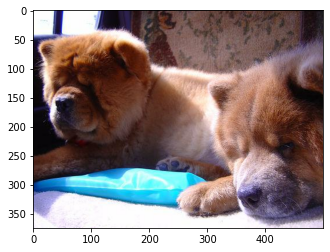

In [14]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

`grad_cam`은 관찰을 원하는 레이어와 정답 클래스에 대한 예측값 사이의 그래디언트를 구하고, 여기에 GAP 연산을 적용함으로써 관찰 대상이 되는 레이어의 채널별 가중치를 구합니다. 최종 CAM 이미지를 구하기 위해서는 레이어의 채널별 가중치(weights)와 레이어에서 나온 채널별 특성 맵을 가중합해주어 `cam_image`를 얻게 됩니다.

이전 스텝에서 본 CAM 함수와 달리, Grad-CAM은 이번에는 어떤 레이어든 CAM 이미지를 뽑아낼 수 있으므로, 그래디언트 계산을 원하는 관찰 대상 레이어 activation_layer를 뽑아서 쓸 수 있도록 `activation_layer`의 이름을 받고 이를 활용해야 합니다.

아래 `generate_grad_cam()`에서는 원하는 레이어의 output과 특정 클래스의 prediction 사이의 그래디언트 `grad_val`을 얻고 이를 weights로 활용합니다.

In [15]:
def generate_grad_cam(model, activation_layer, item):
  item = copy.deepcopy(item)
  width = item['image'].shape[1]
  height = item['image'].shape[0]
  img_tensor, class_idx = normalize_and_resize_img(item)

  # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
  # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
  grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
  # Gradient를 얻기 위해 tape를 사용합니다.
  with tf.GradientTape() as tape:
      conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
      loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
      output = conv_output[0] # 원하는 layer의 output을 얻습니다.
      grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

  weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 weight를 구합니다.
  grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
  for k, w in enumerate(weights):
      # output의 k번째 채널과 k번째 weight를 곱하고 누적해서 class activation map을 얻습니다.
      grad_cam_image += w * output[:, :, k]
        
  grad_cam_image = tf.math.maximum(0, grad_cam_image)
  grad_cam_image /= np.max(grad_cam_image)
  grad_cam_image = grad_cam_image.numpy()
  grad_cam_image = cv2.resize(grad_cam_image, (width, height))
  return grad_cam_image

이제 만든 함수로 여러 레이어의 CAM 이미지를 뽑아서 직접 확인해보세요! 레이어의 이름은 이전 스탭의 `cam_model.summary()` 결과에서 찾을 수 있습니다.

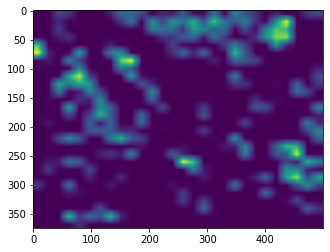

In [18]:
grad_cam_image1 = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image1)
plt.show()

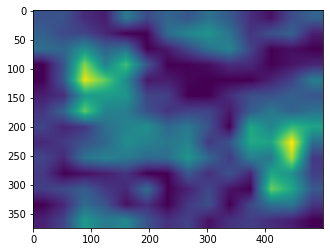

In [19]:
grad_cam_image2 = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image2)
plt.show()

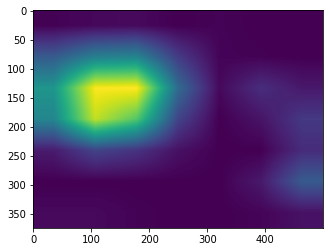

In [20]:
grad_cam_image3 = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image3)
plt.show()

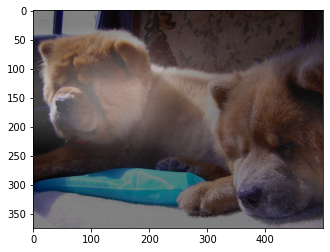

In [24]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image3_3channel = np.stack([grad_cam_image3*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(grad_cam_image3_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

# 3. 바운딩 박스 구하기

* 제시된 코드를 참고해, 직접 제시된 코드를 참고해, 직접 Grad-CAM으로 얻은 CAM을 통해서 바운딩 박스를 얻어보세요.

* 바운딩 박스를 시각화해 보세요.

108


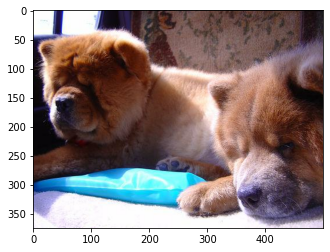

In [77]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

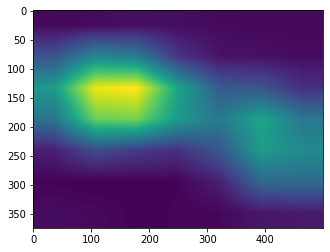

In [78]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

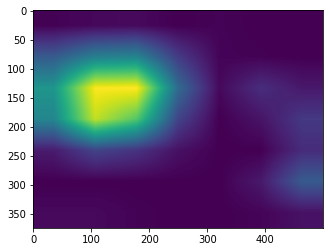

In [79]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

In [80]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [81]:
rect_1 = get_bbox(cam_image)
rect_1

array([[-52, 258],
       [ 12, -17],
       [561, 112],
       [495, 389]])

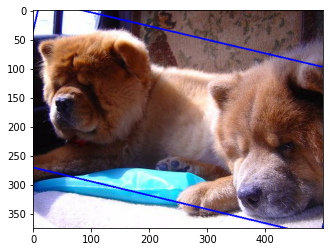

In [82]:
image_1 = copy.deepcopy(item['image'])
image_1 = cv2.drawContours(image_1, [rect_1], 0, (0,0,255), 2)
plt.imshow(image_1)
plt.show()

In [83]:
rect_2 = get_bbox(grad_cam_image)
rect_2

array([[340, 100],
       [499, 100],
       [499, 347],
       [340, 347]])

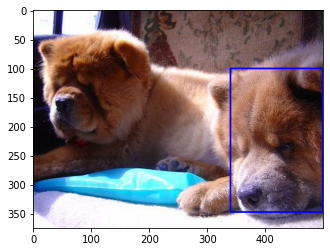

In [84]:
image_2 = copy.deepcopy(item['image'])
image_2 = cv2.drawContours(image_2, [rect_2], 0, (0,0,255), 2)
plt.imshow(image_2)
plt.show()

# IoU

1. 정답 바운딩 박스(ground truth) 와 예측값 바운딩 박스(prediction box) 두 가지를 이용해서 IoU를 계산하는 get_iou() 함수를 만들어 주세요.

2. CAM과 Grad-CAM으로 얻은 바운딩 박스와 정답 바운딩 박스와의 IoU를 각각 비교해 봅시다.

In [85]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect_1, image_1):
    bbox1 = [
        rect_1[:,1].min()/float(image_1.shape[0]),  #bounding box의 y_min
        rect_1[:,0].min()/float(image_1.shape[1]),  #bounding box의 x_min
        rect_1[:,1].max()/float(image_1.shape[0]), #bounding box의 y_max
        rect_1[:,0].max()/float(image_1.shape[1]) #bounding box의 x_max
    ]
    return bbox1

def rect_to_minmax(rect_2, image_2):
    bbox1 = [
        rect_2[:,1].min()/float(image_2.shape[0]),  #bounding box의 y_min
        rect_2[:,0].min()/float(image_2.shape[1]),  #bounding box의 x_min
        rect_2[:,1].max()/float(image_2.shape[0]), #bounding box의 y_max
        rect_2[:,0].max()/float(image_2.shape[1]) #bounding box의 x_max
    ]
    return bbox1

In [86]:
pred_bbox_1 = rect_to_minmax(rect_1, item['image'])
pred_bbox_1

[-0.04533333333333334, -0.104, 1.0373333333333334, 1.122]

In [87]:
pred_bbox_2 = rect_to_minmax(rect_2, item['image'])
pred_bbox_2

[0.26666666666666666, 0.68, 0.9253333333333333, 0.998]

In [88]:
item['objects']['bbox']

array([[0.13066667, 0.488     , 0.96533334, 0.998     ],
       [0.072     , 0.        , 0.784     , 0.678     ]], dtype=float32)

In [89]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [90]:
# CAM에서 얻은 바운딩 박스와 정답 바운딩 박스 간의 IoU
get_iou(pred_bbox_1, item['objects']['bbox'][0])

0.3206992846709983

In [91]:
# Grad-CAM에서 얻은 바운딩 박스와 정답 바운딩 박스 간의 IoU
get_iou(pred_bbox_2, item['objects']['bbox'][0])

0.49205038761587705

# ✍ 루브릭

|평가문항|상세기준|결과|
|-------|-------|:------:|
|1. CAM을 얻기 위한 기본모델의 구성과 학습이 정상 진행되었는가?|ResNet50 + GAP + DenseLayer 결합된 CAM 모델의 학습과정이 안정적으로 수렴하였다.|O|
|2. 분류근거를 설명 가능한 Class activation map을 얻을 수 있는가?|CAM 방식과 Grad-CAM 방식의 class activation map이 정상적으로 얻어지며, 시각화하였을 때 해당 object의 주요 특징 위치를 잘 반영한다.|O|
|3. 인식결과의 시각화 및 성능 분석을 적절히 수행하였는가?|CAM과 Grad-CAM 각각에 대해 원본이미지합성, 바운딩박스, IoU 계산 과정을 통해 CAM과 Grad-CAM의 object localization 성능이 비교분석되었다.|O|

# 회고

1. 이번 프로젝트는 이미지 내 객체의 클래스를 구분지을 수 있도록 하는 활성화 지도(activation map)를 나타내는 CAM을 구현해내는 프로젝트였다.

2. CAM(Class Activation Map) 은 특성을 추출하는 CNN 네트워크 뒤에 GAP(Global Average Pooling)와 소프트맥스 레이어(softmax layer)가 붙는 형태로 구성되어야 한다는 제약이 있는 반면에 Grad-CAM은 이러한 제약이 없다. Grad-CAM은 CAM의 일반화이며 범용적으로 CAM을 사용하게 된다.

3. 이미지는 2마리의 개가 있는 이미지를 활용했고, 둘 간의 IoU를 비교해 보면 Grad-CAM이 CAM보다 수치가 높다.  

CAM의 IoU : 0.3206992846709983  
Grad-CAM의 IoU : 0.47660929003452446  

IoU를 비교하는 의의가 찾고자 하는 물건의 절대적인 면적과 상관없이, 영역을 정확하게 잘 찾아내었는지의 상대적인 비율을 구할 수 있으므로, 모델이 영역을 잘 찾았는지 비교하는 좋은 지표라는 점이다. Grad-CAM이 모델 구현함에 있어서 제약이 덜하고 IoU가 더 높게 측정되었기 때문에 비교적 범용성이 높지 않을까 하는 생각이 들었다.

4. 다만 사진마다 IoU의 값은 천차만별이었다. 개가 한 마리 뿐인 사진의 경우는 오히려 CAM의 경우가 Grad-CAM에 비해 IoU가 높았다. 이건 왜 그럴까?

4. 프로젝트를 하면서 Grad-CAM의 단점을 발견할 수 있었는데 바로 하나의 이미지에서 같은 클래스의 물체가 여럿 발생하는 경우 일부를 구별해내지 못한다는 점이었다. 실제 개 2마리가 있는 사진의 바운딩박스를 보게 되면 CAM의 경우는 두 마리를 모두 인지한 것처럼 보이지만 Grad-CAM의 경우는 한 마리만 인지한 것으로 나왔다.

5. 끝으로 이러한 단점이 프로젝트를 통해 여실히 드러났다는 점이 되게 신기하게 다가왔고, Grad-CAM의 한계를 극복한 Grad-CAM++에 관해서도 알게 되었다.

# Reference

1. CAM, Grad-CAM 논문 리뷰 : https://velog.io/@tobigs_xai/CAM-Grad-CAM-Grad-CAMpp

2. 선배 그루분의 프로젝트 : https://github.com/ljh415/AIFFEL/blob/master/Going_Deeper/05.CAM_GradCam/cam_gradcam.ipynb

3. CAM and Grad-CAM 설명 : https://tyami.github.io/deep%20learning/CNN-visualization-Grad-CAM/